## Toxicity Baseline NB by Sub Categories Seperate vocab
Competition location:  
https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification  
https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

In [1]:
import numpy as np
import pandas as pd
import vocab as vocabulary
import collections
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Load data

In [2]:
train = pd.read_csv('/data/ToxicityData/train.csv')
test = pd.read_csv('/data/ToxicityData/test.csv')

In [3]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


### Tokenization
This can be as simple as calling string.split() - good enough for English and many European languages - but we could also do something more sophisticated here. There are various types of tokenizers:  
  
1. nltk.tokenize.treebank import TreebankWordTokenizer
2. nltk.tokenize import WhitespaceTokenizer

In [4]:
from nltk.tokenize import WhitespaceTokenizer
white_token = WhitespaceTokenizer()

In [5]:
from keras.preprocessing.text import Tokenizer
keras_token = Tokenizer()

Using TensorFlow backend.


In [6]:
V = 30000
SEED = 23
VAL_SPLIT = 0.3

#### First, tokenize everything to build vocab
Only use vocabs from train data.

In [7]:
from nltk.corpus import stopwords

def check_frequency(data, n = 20):
    stop = stopwords.words('english')
    data  = data.apply(lambda x: " ".join(x.lower() for x in x.split()))
    data = data.str.replace('[^\w\s]','')
    data = data.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    freq = pd.Series(' '.join(data).split()).value_counts()[:n]
    return freq



### Look at some of the common words for those with high targets

In [18]:
check_frequency(data = train['comment_text'], n = 10)

would     301263
people    299566
one       256929
like      254760
dont      218081
trump     207496
get       196602
us        194333
time      155511
think     149475
dtype: int64

In [19]:
check_frequency(data = train[train['target'] > 0.5]['comment_text'], n = 10)

trump     21314
people    19137
like      17986
stupid    13054
would     12985
dont      12800
one       12589
get       11991
us         8988
think      8155
dtype: int64

In [20]:
check_frequency(data = train[train['severe_toxicity'] > 0.5]['comment_text'], n = 10)

shit     5
kill     5
hate     4
burn     4
cut      3
white    3
like     3
time     3
lets     3
dogs     2
dtype: int64

In [21]:
check_frequency(data = train[train['obscene'] > 0.5]['comment_text'], n = 10)

crap      1323
damn      1319
like      1263
people    1236
get       1138
dont      1070
would      902
trump      897
one        868
ass        717
dtype: int64

In [22]:
check_frequency(data = train[train['identity_attack'] > 0.5]['comment_text'], n = 10)

white      3258
black      2325
people     2150
muslims    1323
muslim     1081
like       1076
gay        1014
dont        961
would       907
one         800
dtype: int64

In [23]:
check_frequency(data = train[train['insult'] > 0.5]['comment_text'], n = 10)

trump     17863
like      13927
people    13730
stupid    12464
would      9538
one        9412
dont       9319
get        8813
us         6759
think      6213
dtype: int64

In [24]:
check_frequency(data = train[train['threat'] > 0.5]['comment_text'], n = 10)

kill      726
shoot     351
would     292
people    277
get       272
death     229
like      220
dont      205
one       198
die       198
dtype: int64

In [25]:
check_frequency(data = train[train['sexual_explicit'] > 0.5]['comment_text'], n = 10)

sex       853
ass       568
like      448
get       413
women     402
sexual    382
trump     367
dont      354
one       354
would     345
dtype: int64

In [7]:
tokenize_all_one_list = white_token.tokenize(' '.join(train['comment_text'].tolist()))

In [8]:
len(set(tokenize_all_one_list))

1670966

There are 1.67 million tokens, do not have to use all of them as tokens

In [9]:
collections.Counter(tokenize_all_one_list).most_common(20)

[('the', 4261263),
 ('to', 2611234),
 ('and', 2096691),
 ('of', 2021781),
 ('a', 1880032),
 ('is', 1454734),
 ('in', 1294522),
 ('that', 1163635),
 ('for', 911179),
 ('I', 861783),
 ('you', 734810),
 ('are', 714218),
 ('be', 618319),
 ('not', 613791),
 ('have', 598834),
 ('it', 598509),
 ('on', 577471),
 ('with', 556536),
 ('as', 471924),
 ('they', 464629)]

In [10]:
collections.Counter(tokenize_all_one_list).most_common(V)[-1]

('trials.', 141)

#### The 30kth token has 140 appearances, not too bad, we will use top 30k covab, and leave the rest as unknown
This step takes a long time.

In [11]:
vocab = vocabulary.Vocabulary(tokenize_all_one_list, size=30000)

In [12]:
x_train = [vocab.words_to_ids(white_token.tokenize(train_row)) for train_row in train['comment_text'].tolist()]
x_test = [vocab.words_to_ids(white_token.tokenize(test_row)) for test_row in test['comment_text'].tolist()]

In [13]:
y_train = np.array(train['target'] > 0.3)
y_sevtox_train = np.array(train['severe_toxicity'] > 0.3)
y_obs_train = np.array(train['obscene'] > 0.3)
y_idat_train = np.array(train['identity_attack'] > 0.3)
y_ins_train = np.array(train['insult'] > 0.3)
y_thr_train = np.array(train['threat'] > 0.3)
y_expl_train = np.array(train['sexual_explicit'] > 0.3)


In [14]:
y_train = np.array([1 if i else 0 for i in y_train])
y_sevtox_train = np.array([1 if i else 0 for i in y_sevtox_train])
y_obs_train = np.array([1 if i else 0 for i in  y_obs_train])
y_idat_train = np.array([1 if i else 0 for i in y_idat_train])
y_ins_train = np.array([1 if i else 0 for i in  y_ins_train])
y_thr_train = np.array([1 if i else 0 for i in y_thr_train])
y_expl_train = np.array([1 if i else 0 for i in y_expl_train])


## Show some examples by each sub category

In [15]:

i = 0

for ind, y in enumerate(y_sevtox_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

22536
Fuck this asshole and fuck ADN with it's fascist peer reviewed comment censorship.
id                                                                                269682
target                                                                          0.971429
comment_text                           Fuck this asshole and fuck ADN with it's fasci...
severe_toxicity                                                                 0.342857
obscene                                                                         0.914286
identity_attack                                                                0.0571429
insult                                                                          0.885714
threat                                                                         0.0285714
asian                                                                                NaN
atheist                                                                              NaN
bisexual             

In [16]:

i = 0

for ind, y in enumerate(y_obs_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

5
ur a sh*tty comment.
id                                                             59859
target                                                      0.666667
comment_text                                    ur a sh*tty comment.
severe_toxicity                                             0.047619
obscene                                                     0.638095
identity_attack                                                    0
insult                                                      0.333333
threat                                                             0
asian                                                            NaN
atheist                                                          NaN
bisexual                                                         NaN
black                                                            NaN
buddhist                                                         NaN
christian                                                        NaN
female     

In [17]:

i = 0

for ind, y in enumerate(y_idat_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

31
Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?
id                                                                                239607
target                                                                            0.9125
comment_text                           Yet call out all Muslims for the acts of a few...
severe_toxicity                                                                     0.05
obscene                                                                           0.2375
identity_attack                                                                   0.6125
insult                                                                            0.8875
threat                                                                            0.1125
asian                                                                                  0

In [18]:

i = 0

for ind, y in enumerate(y_ins_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

4
haha you guys are a bunch of losers.
id                                                                    59856
target                                                             0.893617
comment_text                           haha you guys are a bunch of losers.
severe_toxicity                                                   0.0212766
obscene                                                                   0
identity_attack                                                   0.0212766
insult                                                              0.87234
threat                                                                    0
asian                                                                     0
atheist                                                                   0
bisexual                                                                  0
black                                                                     0
buddhist                                         

In [19]:

i = 0

for ind, y in enumerate(y_thr_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

1350
LTD needs to be neutered.
id                                                            242254
target                                                           0.7
comment_text                               LTD needs to be neutered.
severe_toxicity                                                    0
obscene                                                            0
identity_attack                                                    0
insult                                                           0.1
threat                                                           0.7
asian                                                            NaN
atheist                                                          NaN
bisexual                                                         NaN
black                                                            NaN
buddhist                                                         NaN
christian                                                        NaN
fem

In [20]:

i = 0

for ind, y in enumerate(y_expl_train):

    if y == 1:
        print(ind)
        print(train.iloc[ind,2])       
        print(train.iloc[ind,:])
        i += 1
        if i > 3:
            break

59
Send more dildos, STAT.
id                                                            239655
target                                                      0.361111
comment_text                                 Send more dildos, STAT.
severe_toxicity                                            0.0416667
obscene                                                    0.0833333
identity_attack                                                    0
insult                                                     0.0416667
threat                                                             0
asian                                                            NaN
atheist                                                          NaN
bisexual                                                         NaN
black                                                            NaN
buddhist                                                         NaN
christian                                                        NaN
female 

## Sub class correlation
### Make all the labels into one matrix
And analyze the correlation between them

In [21]:
train[:2]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [22]:
Targets = train[['target','severe_toxicity','obscene','identity_attack','insult','threat','sexual_explicit']]

In [23]:
Targets[:10]

,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.893617,0.021277,0.000000,0.021277,0.872340,0.0,0.000000
5,0.666667,0.047619,0.638095,0.000000,0.333333,0.0,0.009524
6,0.457627,0.050847,0.305085,0.000000,0.254237,0.0,0.220339
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [24]:
Targets.corr(method='pearson')

,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
target,1.000000,0.393425,0.493058,0.450017,0.928207,0.287761,0.252507
severe_toxicity,0.393425,1.000000,0.340570,0.256599,0.324847,0.277789,0.196876
obscene,0.493058,0.340570,1.000000,0.124823,0.427176,0.090928,0.333666
identity_attack,0.450017,0.256599,0.124823,1.000000,0.310748,0.146662,0.118191
insult,0.928207,0.324847,0.427176,0.310748,1.000000,0.108575,0.145127
threat,0.287761,0.277789,0.090928,0.146662,0.108575,1.000000,0.088051
sexual_explicit,0.252507,0.196876,0.333666,0.118191,0.145127,0.088051,1.000000


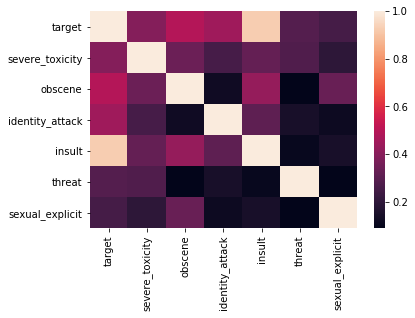

In [25]:


ax = sns.heatmap(Targets.corr(method='pearson'))

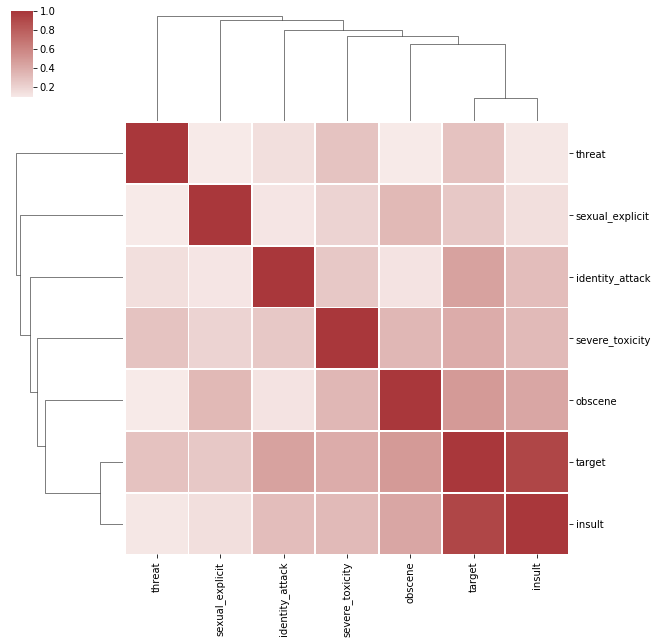

In [26]:
# # Draw the full plot
sns.clustermap(Targets.corr(method='pearson'), center=0, cmap="vlag",
               linewidths=.75, figsize=(10, 10), method = 'average' )

This is interesting, target is highly correlated with 'insult'. This is probably because every time insult is high, target is high, meaning that all other categories can be viewed as insult. However, sexual explicit and threat could be different, i.e. for other types of negative comment, these two won't get flagged. 

## Predict by sub categories
Have to divide trainin

In [27]:
rng = np.random.RandomState(SEED)

indices = np.arange(len(x_train))

rng.shuffle(indices)  # in-place

x_train =  np.array(x_train)
y_train =  np.array(y_train)


# the indices slicing only works with np array

x_train_s = x_train[indices]
y_train_s = y_train[indices]

y_sevtox_train_s = y_sevtox_train[indices]
y_obs_train_s = y_obs_train[indices]
y_idat_train_s = y_idat_train[indices]
y_ins_train_s = y_ins_train[indices]
y_thr_train_s = y_thr_train[indices]
y_expl_train_s = y_expl_train[indices]

split_idx = int(VAL_SPLIT * len(x_train))
val_x = x_train_s[:split_idx]
val_y = y_train_s[:split_idx]

val_y_sevtox = y_sevtox_train[:split_idx]
val_y_obs = y_obs_train[:split_idx]
val_y_idat = y_idat_train[:split_idx]
val_y_ins = y_ins_train[:split_idx]
val_y_thr = y_thr_train[:split_idx]
val_y_expl = y_expl_train[:split_idx]

train_x = x_train_s[split_idx:]
train_y  = y_train_s[split_idx:]

train_y_sevtox = y_sevtox_train[split_idx:]
train_y_obs = y_obs_train[split_idx:]
train_y_idat = y_idat_train[split_idx:]
train_y_ins = y_ins_train[split_idx:]
train_y_thr = y_thr_train[split_idx:]
train_y_expl = y_expl_train[split_idx:]


In [28]:
train_x_sb = utils.id_lists_to_sparse_bow(train_x, V)
val_x_sb = utils.id_lists_to_sparse_bow(val_x, V)


### Unlike the previous case, we use 0.3 as the threshhold as determining if a label is toxic (down from 0.5)

#### precision: how many predicted positive are actually positive
#### recall: how much positive cases did you catch (doesn't work as well when large false positive)

In [37]:

nb = MultinomialNB()

print(train_x_sb[3][(0, 5)])
print(train_y[3])
print(val_x_sb[3][(0, 6)])
print(val_y[3])
print(train_x_sb.shape[0])
nb.fit(train_x_sb, train_y)
y_pred_val = nb.predict(val_x_sb)


acc = accuracy_score(val_y, y_pred_val)
print("Accuracy on test set: {:.02%}".format(acc))

precision, recall, fscore, support = score(val_y, y_pred_val)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

6
0
8
1
1263412
Accuracy on test set: 86.32%
precision: [0.94696674 0.43150739]
recall: [0.89568903 0.61216558]
fscore: [0.9206144  0.50620066]
support: [479451  62011]


In [38]:
nb_sevtox = MultinomialNB()
nb_sevtox.fit(train_x_sb, train_y_sevtox)
y_pred_val_sevtox = nb.predict(val_x_sb)


acc_sevtox = accuracy_score(val_y_sevtox, y_pred_val_sevtox)
print("Accuracy on test set sevtox: {:.02%}".format(acc_sevtox))

precision, recall, fscore, support = score(val_y_sevtox, y_pred_val_sevtox)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set sevtox: 83.75%
precision: [9.99933846e-01 6.82027440e-05]
recall: [0.8375272  0.16666667]
fscore: [9.11553248e-01 1.36349692e-04]
support: [541426     36]


In [39]:
nb_obs = MultinomialNB()
nb_obs.fit(train_x_sb, train_y_obs)
y_pred_val_obs = nb.predict(val_x_sb)


acc_obs = accuracy_score(val_y_obs, y_pred_val_obs)
print("Accuracy on test set obs: {:.02%}".format(acc_obs))

precision, recall, fscore, support = score(val_y_obs, y_pred_val_obs)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set obs: 83.04%
precision: [0.98958519 0.01009401]
recall: [0.83748281 0.15826056]
fscore: [0.90720278 0.0189776 ]
support: [535851   5611]


In [40]:
nb_idat = MultinomialNB()
nb_idat.fit(train_x_sb, train_y_idat)
y_pred_val_idat = nb.predict(val_x_sb)


acc_idat = accuracy_score(val_y_idat, y_pred_val_idat)
print("Accuracy on test set idat: {:.02%}".format(acc_idat))

precision, recall, fscore, support = score(val_y_idat, y_pred_val_idat)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set idat: 82.90%
precision: [0.98744181 0.0124811 ]
recall: [0.8375163  0.16163698]
fscore: [0.90632065 0.02317287]
support: [534669   6793]


In [41]:
nb_ins = MultinomialNB()
nb_ins.fit(train_x_sb, train_y_ins)
y_pred_val_ins = nb.predict(val_x_sb)


acc_ins = accuracy_score(val_y_ins, y_pred_val_ins)
print("Accuracy on test set ins: {:.02%}".format(acc_ins))

precision, recall, fscore, support = score(val_y_ins, y_pred_val_ins)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set ins: 77.83%
precision: [0.91221838 0.08825435]
recall: [0.83759744 0.16320525]
fscore: [0.8733168  0.11455974]
support: [493890  47572]


In [42]:
nb_thr = MultinomialNB()
nb_thr.fit(train_x_sb, train_y_thr)
y_pred_val_thr = nb.predict(val_x_sb)


acc_thr = accuracy_score(val_y_thr, y_pred_val_thr)
print("Accuracy on test set thr: {:.02%}".format(acc_thr))

precision, recall, fscore, support = score(val_y_thr, y_pred_val_thr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set thr: 83.43%
precision: [0.99512006 0.00521751]
recall: [0.83757308 0.17178144]
fscore: [0.90957483 0.01012742]
support: [538790   2672]


In [43]:
nb_expl = MultinomialNB()
nb_expl.fit(train_x_sb, train_y_expl)
y_pred_val_expl = nb.predict(val_x_sb)


acc_expl = accuracy_score(val_y_expl, y_pred_val_expl)
print("Accuracy on test set expl: {:.02%}".format(acc_expl))

precision, recall, fscore, support = score(val_y_expl, y_pred_val_expl)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

Accuracy on test set expl: 83.38%
precision: [0.99448278 0.00571766]
recall: [0.83755435 0.16738769]
fscore: [0.90929748 0.01105762]
support: [538457   3005]


We can see that most of the problems are insults. And that even though predicted accuracy is high, the precision is rather terrible, meaning that most of our predicted 'toxic comments' are not really toxic.

In [ ]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
# modified to work with current set up

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
# https://github.com/hundredblocks/concrete_NLP_tutorial
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")